<a href="https://colab.research.google.com/github/arguto1993/wordcloud-berita-pusdiklat-bps-2023/blob/main/WordCloud_Berita2600.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [ ]:
!pip install --upgrade wordcloud

In [ ]:
import pandas as pd

Load stopwords

# Load stopwords

## Load STOPWORDS from nltk library

In [ ]:
import nltk  # Example using NLTK
nltk.download('stopwords')  # Download if necessary
STOPWORDS = set(nltk.corpus.stopwords.words('english'))  # Load English stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load stopwords from file (need to upload the file manually to colab files)

In [ ]:
# Load Indonesian stopwords from the file
# with open("stopwords-id.txt", "r") as f:
#     stopwords_id = f.read().splitlines()

# Load Custom stopwords from the file
# with open("stopwords-p.txt", "r") as f:
#     stopwords_p = f.read().splitlines()

## Load stopwords from google drive (recommended)

In [ ]:
import requests

In [ ]:
def download_file_from_drive(file_id, filename):
    """Downloads a file from Google Drive using its ID and saves it to a specified filename."""
    url = f"https://drive.google.com/uc?id={file_id}&export=download"
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
            print(f"Success: {filename} downloaded from Google Drive.")
        return True
    else:
        print(f"Error: Failed to download {filename} from Google Drive.")
        return False

# Download stopwords-id.txt
if download_file_from_drive("1EyhKHCCAJOHBA_iicz4ry-VLcu3RmXZE", "stopwords-id.txt"):
    with open("stopwords-id.txt", "r") as f:
        stopwords_id = f.read().splitlines()

# Download stopwords-p.txt
if download_file_from_drive("12ZjGx05K3FfSeKPyMYhhalrldZHR6Zaz", "stopwords-p.txt"):
    with open("stopwords-p.txt", "r") as f:
        stopwords_p = f.read().splitlines()

Success: stopwords-id.txt downloaded from Google Drive.
Success: stopwords-p.txt downloaded from Google Drive.


# Combine stopwords

In [ ]:
# Combine default and custom stopwords
stopwords_c = set(STOPWORDS).union(stopwords_id).union(stopwords_p)  # Use a set for efficient membership testing
# stopwords_c = stopwords_p

# Load clean dataset (cleaned via [spreadsheets](https://docs.google.com/spreadsheets/d/13hsXm20S6RdAyK520rLLkbbUJEywRp5F/edit?usp=sharing&ouid=101051388151123974532&rtpof=true&sd=true))

In [ ]:
# Google drive file id for clean dataset
file_id = "13hsXm20S6RdAyK520rLLkbbUJEywRp5F"
# Construct the download URL
GSHEET_URL_XLSX = f"https://drive.google.com/uc?id={file_id}&export=download"

# Download the file using requests
response = requests.get(GSHEET_URL_XLSX, stream=True)

with open("berita2600konten.xlsx", 'wb') as f:
    try:
        # for chunk in response.iter_content(chunk_size=2048):
        for chunk in response.iter_content(chunk_size=4048):
            f.write(chunk)
        print("Data download and writing complete!")
    except Exception as e:
        print("An error occurred during download:", e)
        # Implement error-handling logic here (e.g., retrying, logging)

# Specify the engine based on the file format
engine = 'openpyxl'  # For .xlsx files
# engine = 'xlrd'  # For older .xls files

# Read the Excel file using the specified engine
data = pd.read_excel("berita2600konten.xlsx", sheet_name="data_c3", engine=engine)

Data download and writing complete!


In [ ]:
pd.options.display.max_colwidth = 2500  # Set a larger width for full display
print(data["konten_clean"])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
# Clean text (adjust as needed)
clean_text = (
    data["konten_clean"]
        # .str.lower()
        .str.replace(r"\n", " ")  # Remove newlines
        .str.replace(r"<[^>]*>", " ")  # Remove HTML tags
        .str.replace(r"\/.,", " ")  # Remove punctuation (adjust as needed)
)  # Apply cleaning to each row

# Tokenize text
words_per_row = clean_text.apply(word_tokenize)  # Tokenize each row

# Count words in each row and sum across the DataFrame
num_words = words_per_row.apply(len).sum()
print("Number of words (using nltk):", num_words)

# List of words
list_words = words_per_row.sum()  # Sum the word counts in each row
print("List of words (using nltk):", list_words)

<ipython-input-128-11f6e948da5c>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"\n", " ")  # Remove newlines
<ipython-input-128-11f6e948da5c>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"<[^>]*>", " ")  # Remove HTML tags
<ipython-input-128-11f6e948da5c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r"\/.,", " ")  # Remove punctuation (adjust as needed)


Number of words (using nltk): 34623
List of words (using nltk): ['Rapat', 'Koordinasi', 'Pusdiklat', 'BPS', 'dan', 'Universitas', 'Negeri', 'Jakarta', 'Senin', '(', '18/12', ')', 'Pusdiklat', 'BPS', 'menerima', 'kunjungan', 'Tim', 'Pengelola', 'Jurnal', 'Statistika', 'dan', 'Aplikasinya', '(', 'JSA', ')', 'dari', 'Program', 'Studi', 'Statistika', 'Universitas', 'Negeri', 'Jakarta', '(', 'UNJ', ')', '.', 'Dalam', 'sambutannya', 'Koordinator', 'Prodi', 'Statistika', 'Dr.', 'Dian', 'Handayani', 'menyampaikan', 'bahwa', 'JSA', 'yang', 'telah', 'berdiri', 'sejak', 'tahun', '2017', 'menargetkan', 'pada', 'tahun', '2024', 'menjadi', 'jurnal', 'yang', 'memiliki', 'akreditasi', 'internasional', 'terindex', 'Scopus', '.', 'Salah', 'satu', 'syarat', 'yang', 'harus', 'dipenuhi', 'yaitu', 'reviewer', 'dari', 'dosen-dosen', 'luar', 'negeri', '.', 'Untuk', 'itu', 'diharapkan', 'dukungan', 'dari', 'BPS', 'yang', 'memiliki', 'jaringan', 'dengan', 'para', 'dosen', 'dan', 'universitas', 'luar', 'negeri',

# Generate Word Cloud

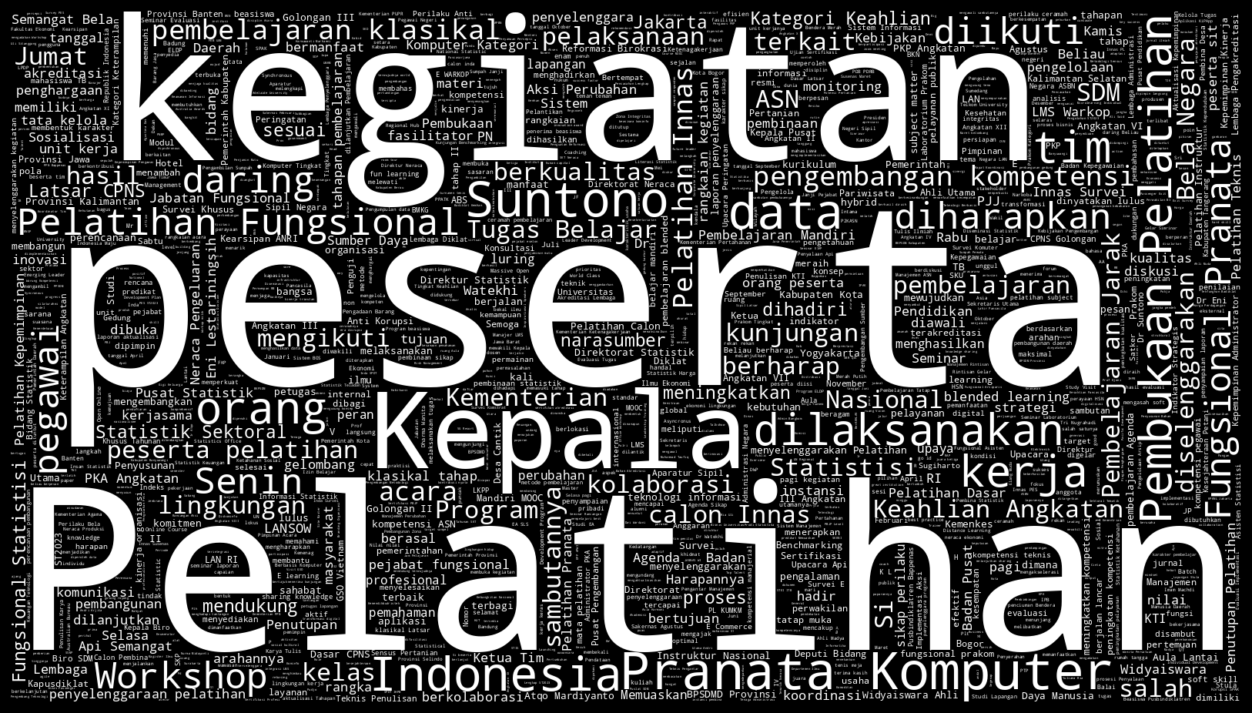

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Function to set text color to white
def white_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "white"

# Load PNG image as a mask
# mask = np.array(Image.open("shape.png"))

# clean_text_string = data["konten_clean"].str.cat()
clean_text_string = data["konten_clean"].str.cat(sep=" ")

# Tokenize the text using nltk
words = word_tokenize(clean_text_string)

# Join the tokenized words into a string
word_string = " ".join(words)

# Generate word cloud with nltk-tokenized text
wordcloud = WordCloud(
    background_color="black",
    max_words=4000,
    stopwords=stopwords_c,
    width=1600,
    height=900,
    contour_width=5,  # This should work now
    contour_color="black",  # This should also work now
    color_func=white_color_func,
    # mask=mask,
).generate(word_string)

# Generate and display the word cloud
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Save the word cloud as an image
wordcloud.to_file("wordcloud_berita2600_2023.png")

# Generate Charts

## Load DataFrame

In [ ]:
# Access raw word frequencies from the generated word cloud
word_counts = wordcloud.process_text(clean_text_string)

# Create a DataFrame of word frequencies
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['freq'])

# Sort by word count in descending order
word_counts_df = word_counts_df.sort_values(by='freq', ascending=False)

# Print the top 10 words and their frequencies
n=10
print(word_counts_df.head(n))

# Optionally, save the DataFrame to a CSV file
# word_counts_df.to_csv(f"top_{n}_words.csv", index=False)

                     freq
peserta               241
Pelatihan             213
kegiatan              154
Kepala                137
Pranata Komputer       91
data                   79
Suntono                78
Indonesia              73
Pembukaan Pelatihan    67
tim                    65


In [ ]:
from collections import Counter  # Import Counter for word counting

# Access the words and frequencies from the generated word cloud
words_and_frequencies = wordcloud.words_

# Count unique words, excluding stopwords
unique_word_count = 0
for word, frequency in words_and_frequencies.items():
    if word not in stopwords_c:  # Check if not a stopword
        unique_word_count += 1

# Print the results
print("Number of unique words (excluding stopwords):", unique_word_count)

Number of unique words (excluding stopwords): 3615


In [ ]:
# word_counts_df

In [ ]:
total_frequency = word_counts_df['freq'].sum()  # Sum all frequencies in the 'freq' column
print("Total frequency of all words & phrases:", total_frequency)
print("Average number of all words & phrases per post:", total_frequency/183)

Total frequency of all words & phrases: 15333
Average number of all words & phrases per post: 83.78688524590164


## Horizontal Bar Chart



<Figure size 1600x900 with 0 Axes>

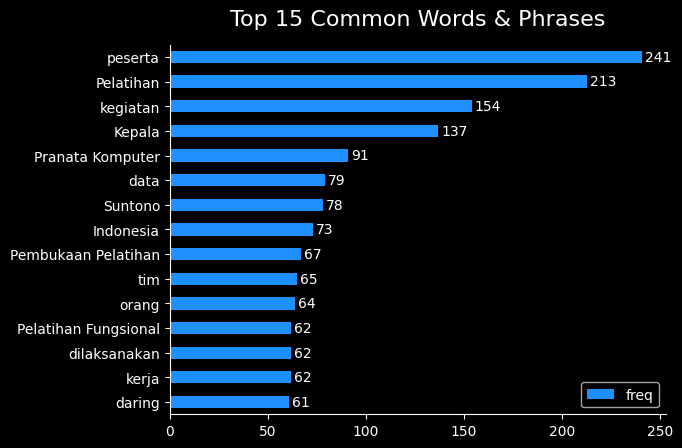

In [ ]:
import matplotlib.pyplot as plt2
plt2.style.use('dark_background')

# Get the top n most common words
n=15
top_n_words = word_counts_df.head(n)

# Create horizontal bar chart with reversed y-axis
plt2.figure(figsize=(16, 9))
ax = top_n_words.plot(kind='barh', color='dodgerblue')  # Set bar color to blue
ax.invert_yaxis()

# Add data labels at the end of each bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() + 1.4, p.get_y() + p.get_height() / 1.2))

# Customize the chart appearance
# plt2.xlabel("Frequency")
# plt2.ylabel("Words/Phrases")

plt2.rcParams['font.size'] = 10  # Set overall font size for text elements
plt2.title(f"Top {n} Common Words & Phrases", y=1.03, fontsize=16)
# plt2.title(f"Top {n} Common Words & Phrases", y=1.03)
# plt2.tight_layout()

# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks from top and right axes
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Show the chart
plt2.draw()
plt2.show()


<Figure size 900x1600 with 0 Axes>

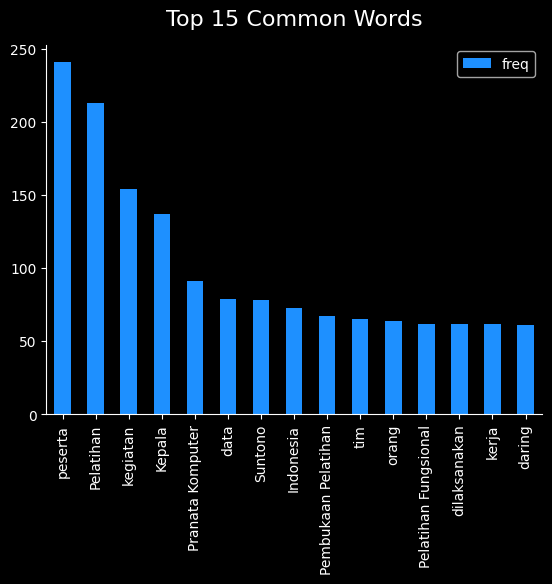

In [ ]:
import matplotlib.pyplot as plt2b

plt2b.style.use('dark_background')

# Get the top n most common words
n=15
top_n_words = word_counts_df.head(n)

# Create vertical bar chart
plt2b.figure(figsize=(9, 16))  # Adjust figure size for vertical bars
ax = top_n_words.plot(kind='bar', color='dodgerblue')  # Create vertical bars

# Remove x-axis labels
# plt2b.xticks([])

# Add data labels at the top of each bar
# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + 5))

# Customize the chart appearance
# plt2b.xlabel("Word/Phrase")
# plt2b.ylabel("Frequency")

# plt2b.rcParams['font.size'] = 10
plt2b.title(f"Top {n} Common Words", y=1.03, fontsize=16)

# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks from top and right axes
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt2b.show()


## Pie Chart

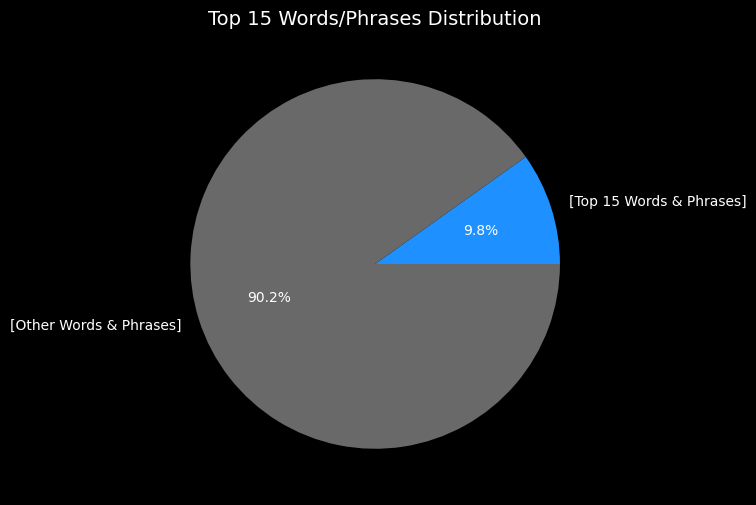

In [ ]:
import matplotlib.pyplot as plt3

# Select top 15 words and aggregate others into "others" category
n = 15
top_n_words = word_counts_df.head(n)
other_words = word_counts_df.tail(-15).sum()

# Combine top 15 words into a single "Top 15 Words" category
top_n_words = top_n_words.sum().rename(f"Top {n} Words")

# Create a DataFrame with the two desired categories
pie_data = pd.DataFrame({'freq': [top_n_words, other_words]}, index=[f'[Top {n} Words & Phrases]', '[Other Words & Phrases]'])

# Create pie chart with blue and light gray colors
colors = ['dodgerblue', 'dimgrey']  # Define the color palette
plt3.figure(figsize=(6, 6))
wedges, texts, autotexts = plt3.pie(pie_data['freq'], labels=pie_data.index, autopct="%1.1f%%", colors=colors)

# Increase font size for all elements
plt3.rcParams['font.size'] = 10  # Set overall font size for text elements

# Adjust title position and font size
plt3.title(f"Top {n} Words/Phrases Distribution", fontsize=14)  # Move title closer and increase font size
plt3.show()
